In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Your other imports and code will go here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Now, any code that would have produced a warning will run silently.

# Load the Dataset

In [3]:
# Load the dataset
path = 'Churn_Modelling.csv'
df = pd.read_csv(path)

In [4]:
# Display the first few rows of the dataset
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [5]:
# Check the shape of the dataset
print("Dataset Shape:",df.shape)

Dataset Shape: (10002, 14)


# Data Cleaning

***RowNumber, CustomerId, and Surname:*** These features are identifiers and do not influence churn prediction, so they can be ignored

In [6]:
# Data Cleaning

# Drop irrelevant columns: RowNumber, CustomerId, Surname
df.drop(["RowNumber","CustomerId","Surname"],axis=1,inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [7]:
#check for missing values
missing_values = df.isnull().sum()
print("Missing Values before filling:\n",missing_values)

Missing Values before filling:
 CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64


In [8]:
#check for duplicated rows in a dataset
duplicated_rows = df[df.duplicated()]

#count the number of duplicates
duplicate_count = duplicated_rows.shape[0]

#display the duplicated rows and count
duplicated_rows, duplicate_count

(       CreditScore Geography  Gender   Age  Tenure    Balance  NumOfProducts  \
 9999           772   Germany    Male  42.0       3   75075.31              2   
 10001          792    France  Female  28.0       4  130142.79              1   
 
        HasCrCard  IsActiveMember  EstimatedSalary  Exited  
 9999         1.0             0.0         92888.52       1  
 10001        1.0             0.0         38190.78       0  ,
 2)

In [9]:
# Remove duplicate rows
df = df.drop_duplicates()

# Recheck the dataset for any remaining duplicate rows
remaining_duplicates = df[df.duplicated()]
num_remaining_duplicates = remaining_duplicates.shape[0]

# Display the count of remaining duplicates
num_remaining_duplicates


0

In [10]:
# Fill missing values for 'HasCrCard' and 'IsActiveMember' using forward fill
df["HasCrCard"] = df["HasCrCard"].ffill()
df["IsActiveMember"] = df["IsActiveMember"].ffill()

# Fill missing value in 'Geography' with the mode (most frequent value)
df["Geography"] =  df["Geography"].fillna(df["Geography"].mode()[0])

# Fill missing value in 'Age' with the median
df["Age"] = df["Age"].fillna(df["Age"].median())

In [11]:
#confirm that all the missing values are filled
missed_val = df.isnull().sum()
print("Missing values after filling:\n",missed_val)

Missing values after filling:
 CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


# Exploratory Data Analysis (EDA)

## 4.1 Univariate Analysis

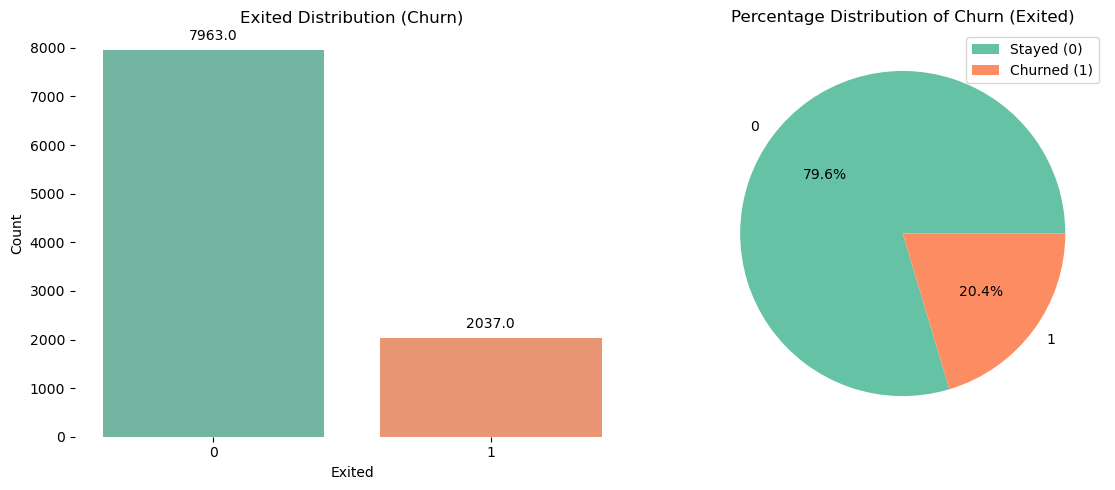

In [12]:
# Create subplots for Exited feature
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
exited_counts = df['Exited'].value_counts()
sns.barplot(x=exited_counts.index, y=exited_counts, ax=axes[0], palette='Set2', hue=exited_counts.index, legend=False)
axes[0].set_title('Exited Distribution (Churn)')
axes[0].set_ylabel('Count')

for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')
sns.despine(left=True, bottom=True) 
    
exited_percentage = df['Exited'].value_counts(normalize=True) * 100
axes[1].pie(exited_percentage, labels=exited_percentage.index, autopct='%1.1f%%', 
            colors=sns.color_palette('Set2'))
axes[1].set_title('Percentage Distribution of Churn (Exited)')
plt.legend(['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

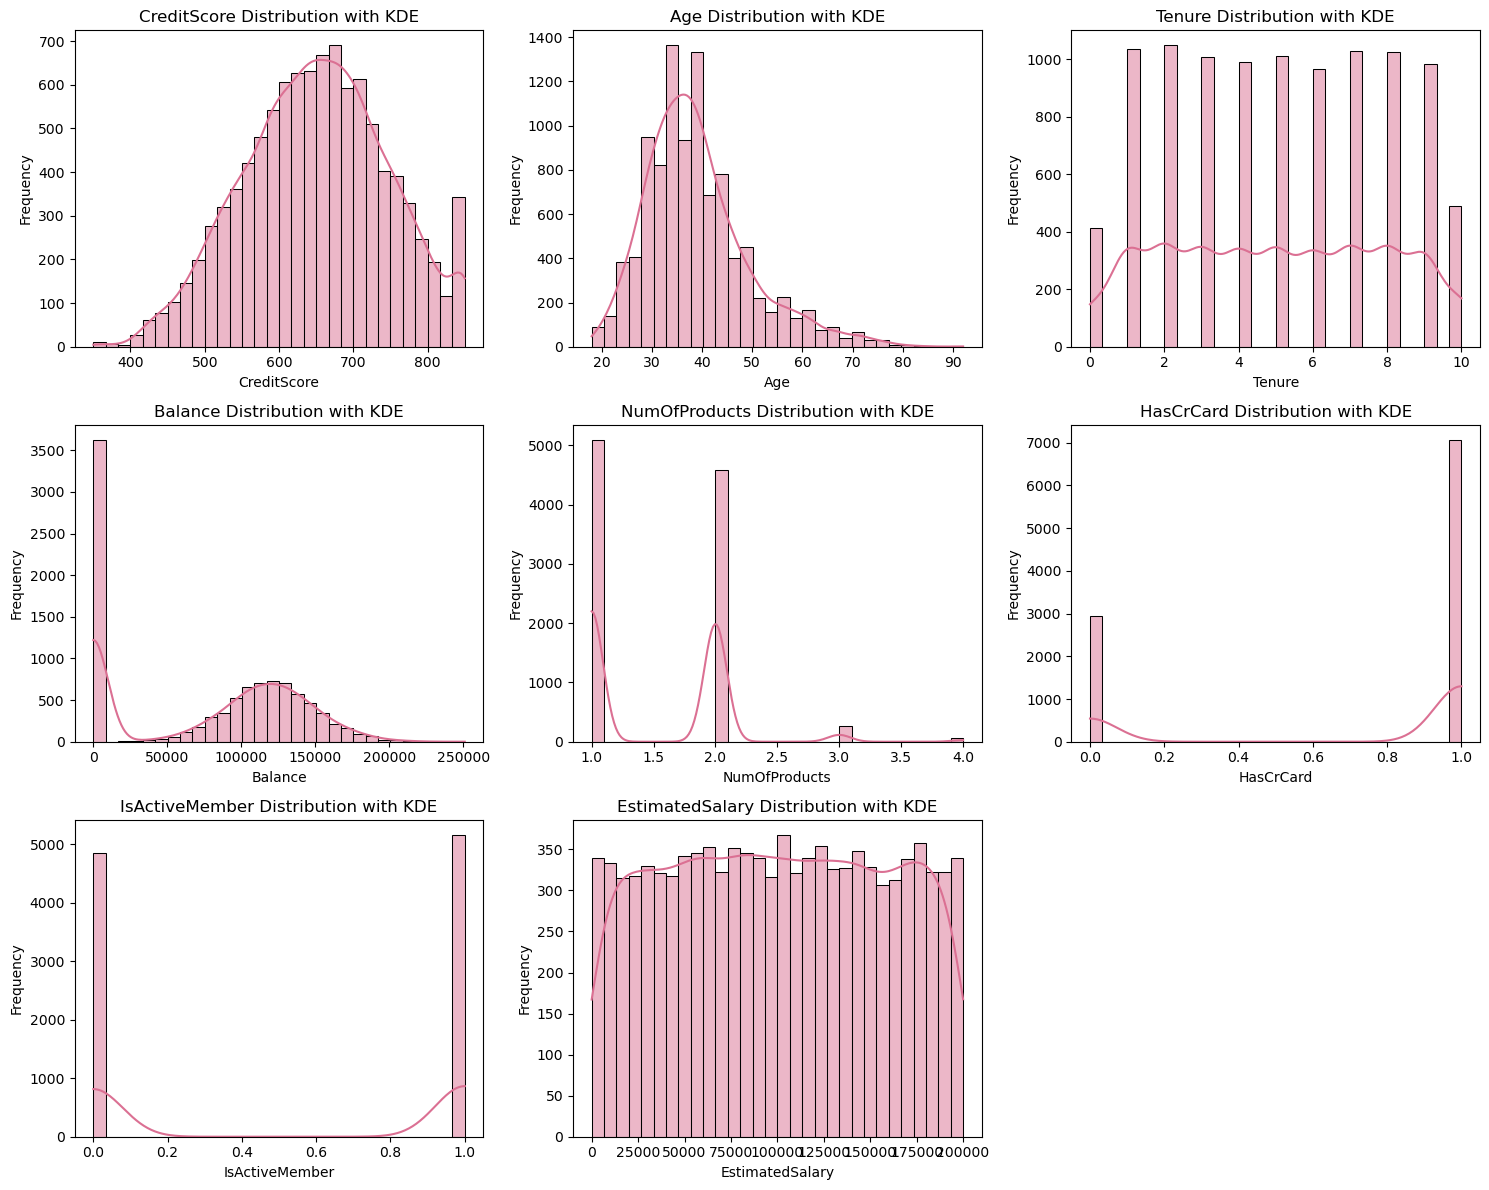

In [13]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, columns):
    plt.figure(figsize=(15, 12))  # Adjust figure size to fit all plots
    
    for i, column in enumerate(columns, 1):
        plt.subplot(3, 3, i)  # Create a 3x3 grid of subplots
        sns.histplot(data[column], kde=True, bins=30, color='palevioletred')
        plt.title(f'{column.replace("_", " ")} Distribution with KDE')
        plt.xlabel(column.replace('_', ' '))
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

columns_to_analyze = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

univariate_analysis(df, columns_to_analyze)

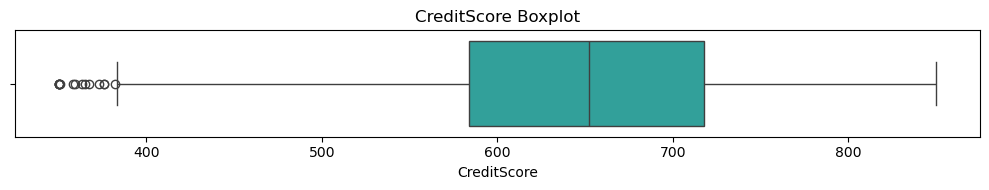


Summary Statistics for CreditScore:
 count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64


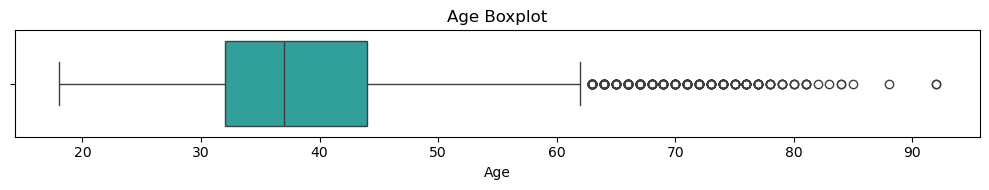


Summary Statistics for Age:
 count    10000.000000
mean        38.922903
std         10.487128
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64


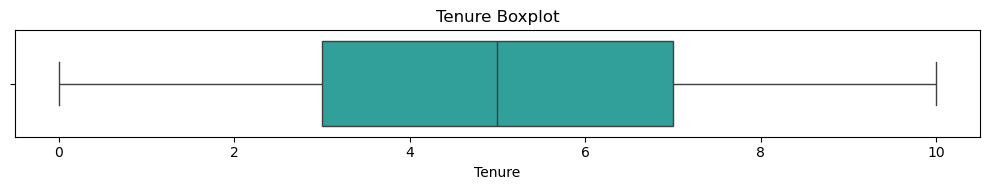


Summary Statistics for Tenure:
 count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64


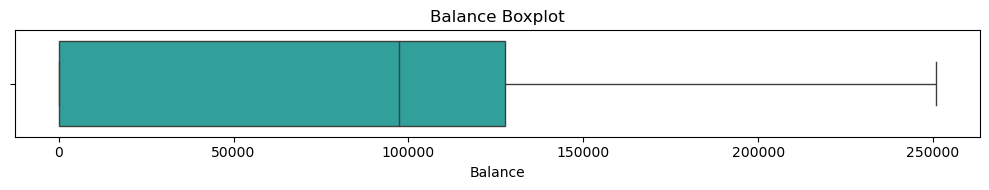


Summary Statistics for Balance:
 count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64


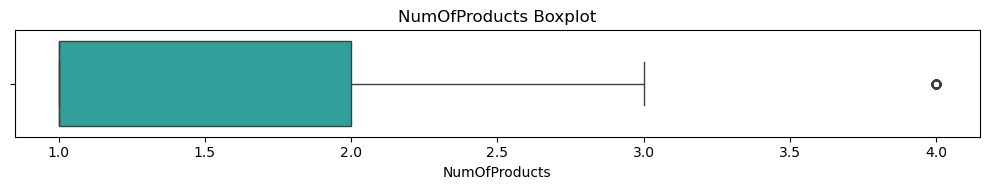


Summary Statistics for NumOfProducts:
 count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: NumOfProducts, dtype: float64


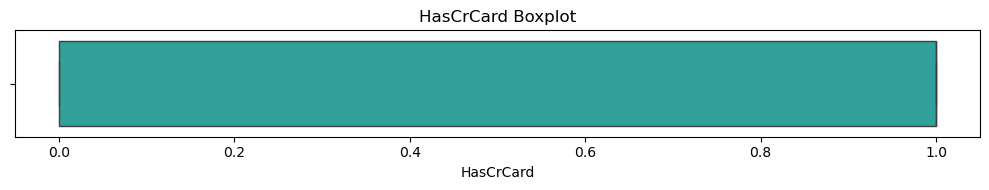


Summary Statistics for HasCrCard:
 count    10000.000000
mean         0.705400
std          0.455886
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HasCrCard, dtype: float64


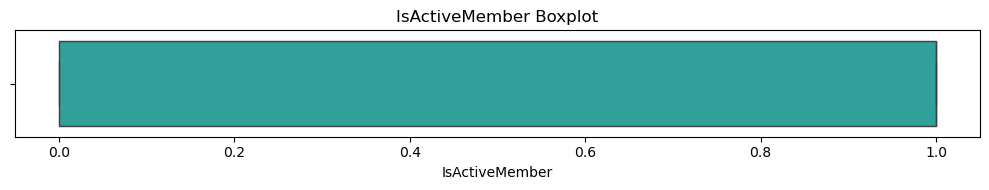


Summary Statistics for IsActiveMember:
 count    10000.0000
mean         0.5150
std          0.4998
min          0.0000
25%          0.0000
50%          1.0000
75%          1.0000
max          1.0000
Name: IsActiveMember, dtype: float64


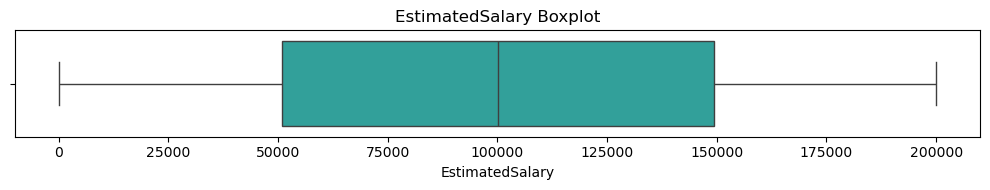


Summary Statistics for EstimatedSalary:
 count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64


In [14]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, column, title):
    plt.figure(figsize=(10, 2))
    
    sns.boxplot(x=data[column], color='lightseagreen')
    plt.title(f'{title} Boxplot')
    
    plt.tight_layout()
    plt.show()

    print(f'\nSummary Statistics for {title}:\n', data[column].describe())

columns_to_analyze = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

for column in columns_to_analyze:
    univariate_analysis(df, column, column.replace('_', ' '))

In [15]:
def plot_categorical_distribution(column_name, data=df):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    sns.countplot(y=column_name, data=df, palette='Set2', hue=column_name, legend=False)

    plt.title(f'Distribution of {column_name}')
    
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha='center', va='center', xytext=(10, 0), textcoords='offset points')
    
    sns.despine(left=True, bottom=True)
    
    plt.subplot(1, 2, 2)
    df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=90, explode=[0.05]*df[column_name].nunique())
    plt.title(f'Percentage Distribution of {column_name}')
    plt.ylabel('')  
    
    plt.tight_layout()
    plt.show()

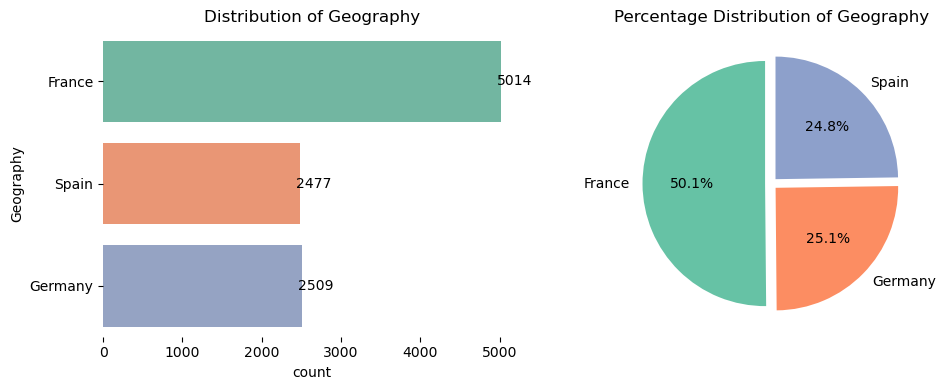

In [16]:
# Plotting for 'Geography' 
plot_categorical_distribution('Geography')

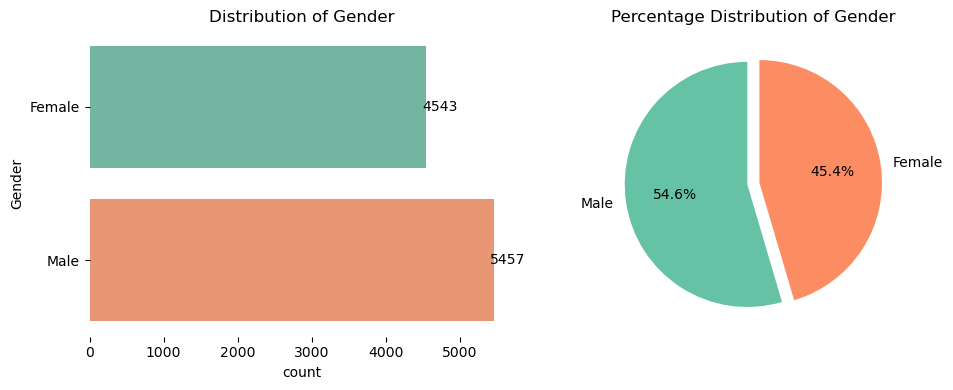

In [17]:
# Plotting for 'Gender' 
plot_categorical_distribution('Gender')

## 4.2 Bivariate Analysis

In [18]:
# Create a crosstab of Geography and Exited
contingency_table = pd.crosstab(df['Geography'], df['Exited'])

# Display the crosstab
print(contingency_table)

Exited        0    1
Geography           
France     4204  810
Germany    1695  814
Spain      2064  413


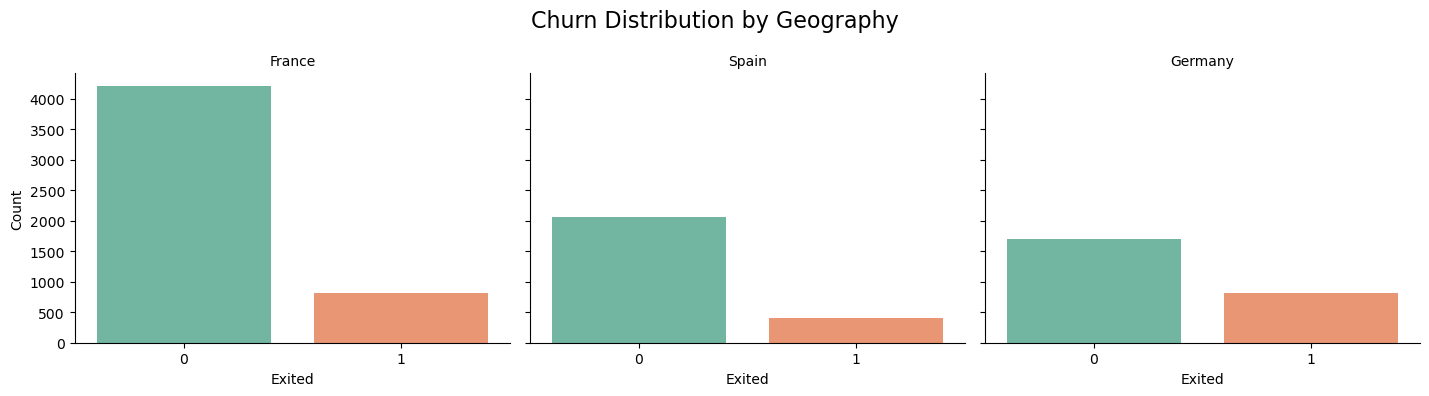

In [19]:
# Create a FacetGrid to visualize Geography by Exited
g = sns.FacetGrid(df, col='Geography', height=4, aspect=1.2)

g.map(sns.countplot, 'Exited', palette='Set2')
g.set_titles("{col_name}")
g.set_axis_labels("Exited", "Count")
g.fig.suptitle('Churn Distribution by Geography', fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
# Create a crosstab of Gender and Exited
contingency_table = pd.crosstab(df['Gender'], df['Exited'])

# Display the crosstab
print(contingency_table)

Exited     0     1
Gender            
Female  3404  1139
Male    4559   898


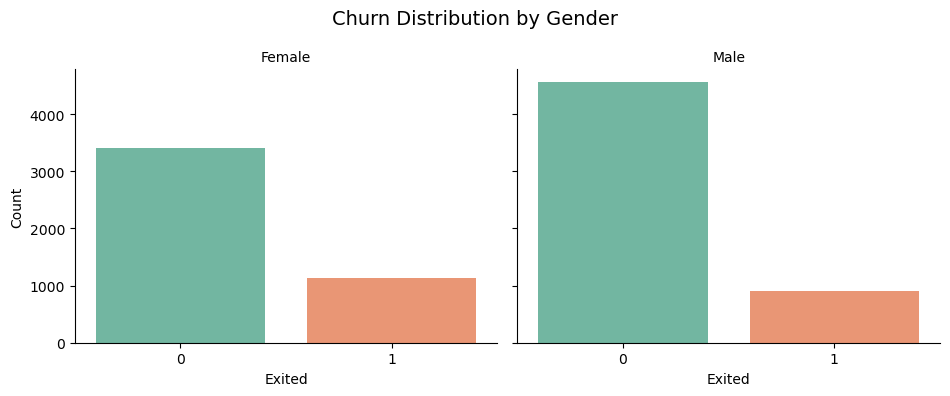

In [21]:
# Create a FacetGrid to visualize Gender by Exited
g = sns.FacetGrid(df, col='Gender', height=4, aspect=1.2)

g.map(sns.countplot, 'Exited', palette='Set2')
g.set_titles("{col_name}")
g.set_axis_labels("Exited", "Count")
g.fig.suptitle('Churn Distribution by Gender', fontsize=14)
plt.tight_layout()
plt.show()

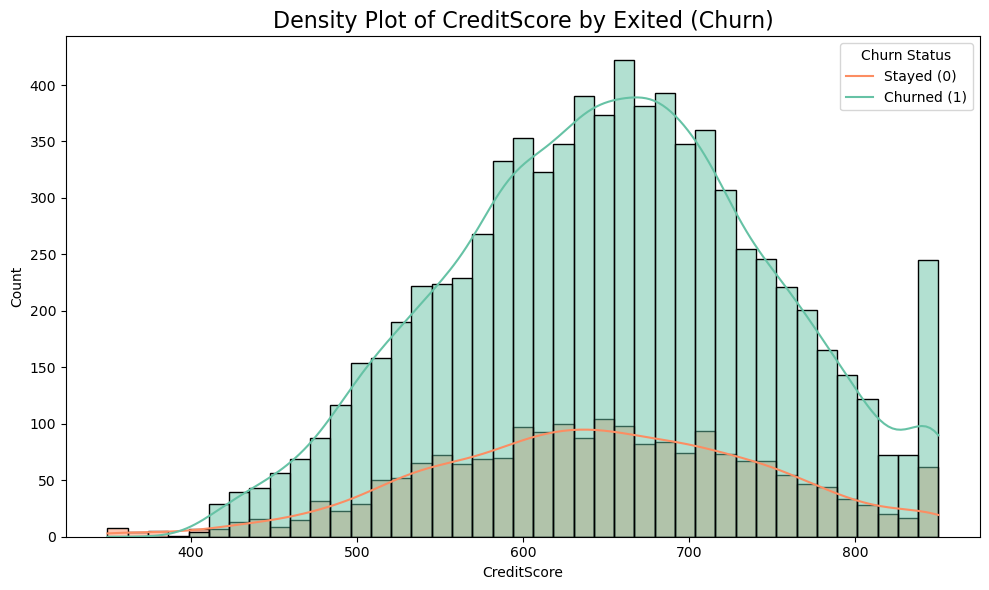

In [22]:
# Create a histplot for CreditScore by Exited
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='CreditScore', hue='Exited', kde=True, fill=True, palette='Set2')
plt.title('Density Plot of CreditScore by Exited (Churn)', fontsize=16)
plt.xlabel('CreditScore')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

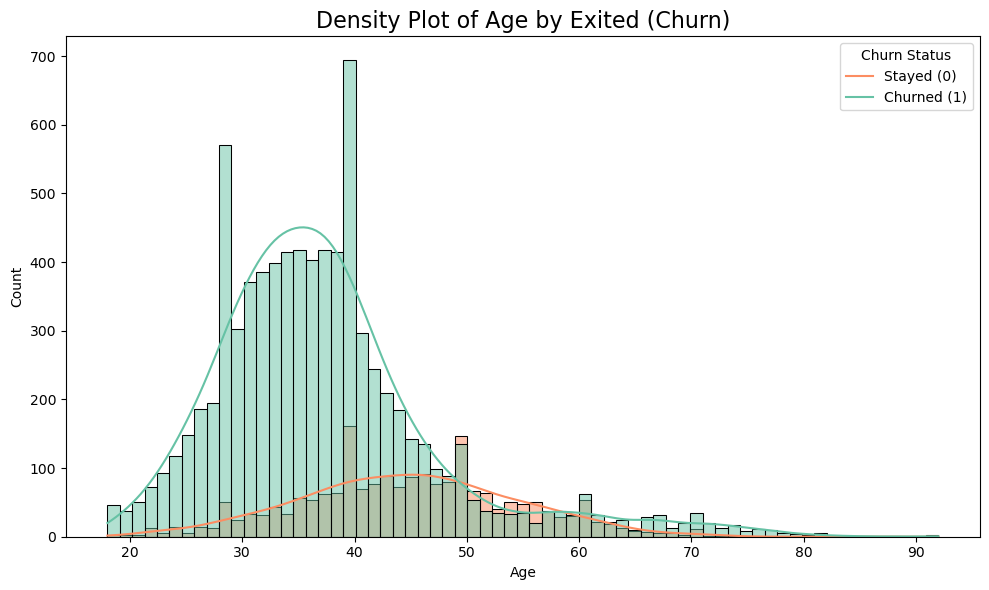

In [23]:
# Create a histplot for Age by Exited
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Exited', kde=True, fill=True, palette='Set2')
plt.title('Density Plot of Age by Exited (Churn)', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

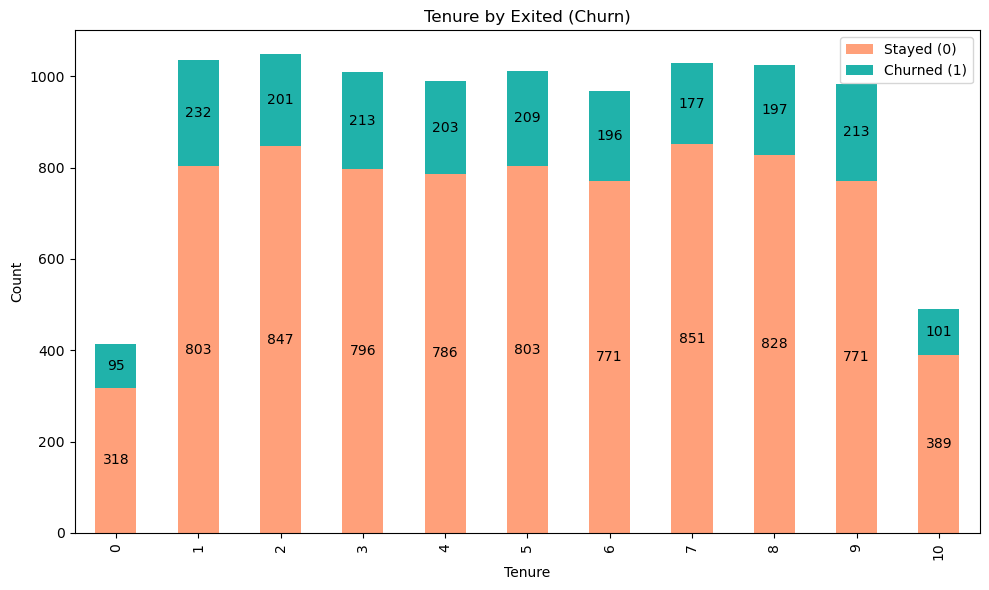

In [24]:
# Group the data by Tenure and Exited to get counts
tenure_exited_counts = df.groupby(['Tenure', 'Exited']).size().unstack()
ax = tenure_exited_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightsalmon', 'lightseagreen'])

plt.title('Tenure by Exited (Churn)')
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.legend(['Stayed (0)', 'Churned (1)'])
plt.tight_layout()

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0:  # Avoid labels for zero heights
        x = p.get_x() + width / 2
        y = p.get_y() + height / 2
        ax.annotate(f'{int(height)}', (x, y), ha='center', va='center')

plt.show()

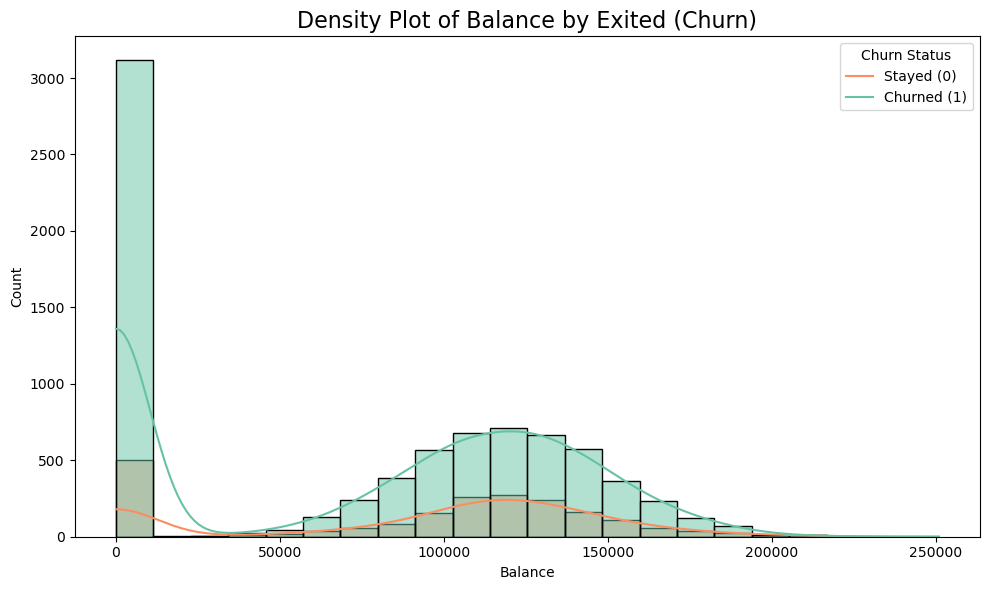

In [25]:
# Create a histplot for Balance by Exited
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Balance', hue='Exited', kde=True, fill=True, palette='Set2')
plt.title('Density Plot of Balance by Exited (Churn)', fontsize=16)
plt.xlabel('Balance')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

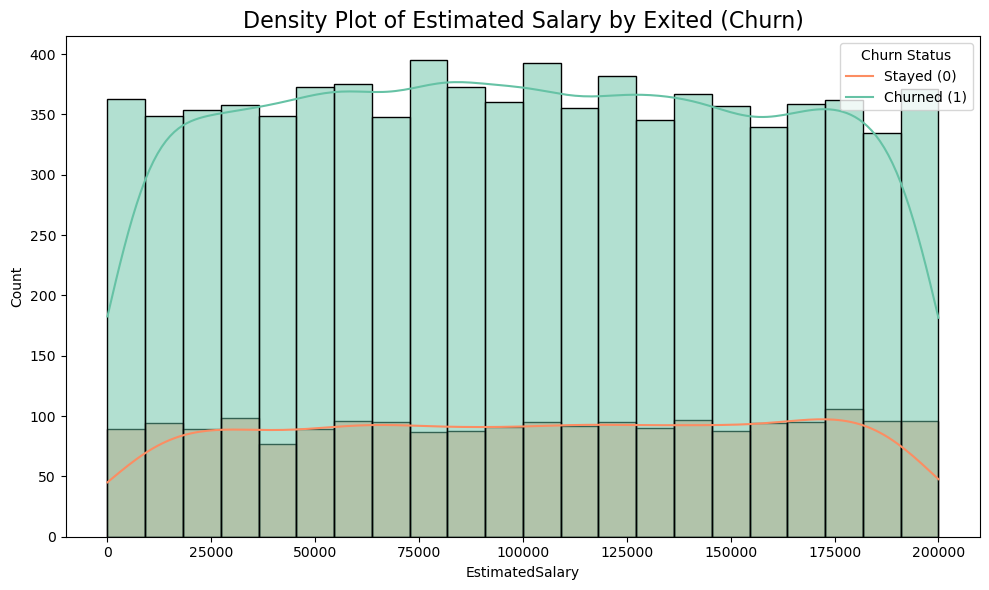

In [26]:
# Create a histplot for EstimatedSalary by Exited
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='EstimatedSalary', hue='Exited', kde=True, fill=True, palette='Set2')
plt.title('Density Plot of Estimated Salary by Exited (Churn)', fontsize=16)
plt.xlabel('EstimatedSalary')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

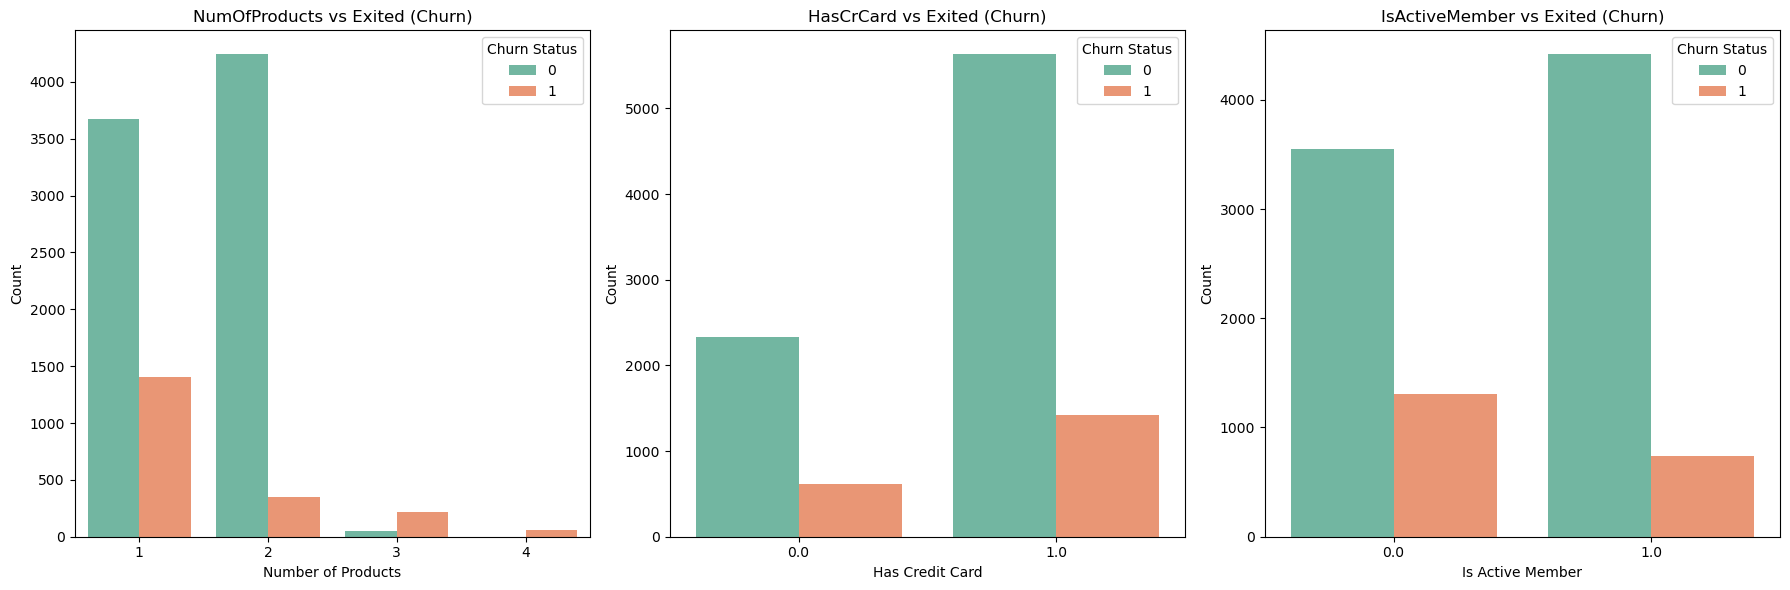

In [27]:
plt.figure(figsize=(18, 6))
    
# Countplot for NumOfProducts vs Exited
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='NumOfProducts', hue='Exited', palette='Set2')
plt.title('NumOfProducts vs Exited (Churn)')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.legend(title='Churn Status')

# Countplot for HasCrCard vs Exited
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='HasCrCard', hue='Exited', palette='Set2')
plt.title('HasCrCard vs Exited (Churn)')
plt.xlabel('Has Credit Card')
plt.ylabel('Count')
plt.legend(title='Churn Status')

# Countplot for IsActiveMember vs Exited
plt.subplot(1, 3, 3)
sns.countplot(data=df, x='IsActiveMember', hue='Exited', palette='Set2')
plt.title('IsActiveMember vs Exited (Churn)')
plt.xlabel('Is Active Member')
plt.ylabel('Count')
plt.legend(title='Churn Status')

plt.tight_layout()
plt.show()

## 4.3 Multivariate Analysis

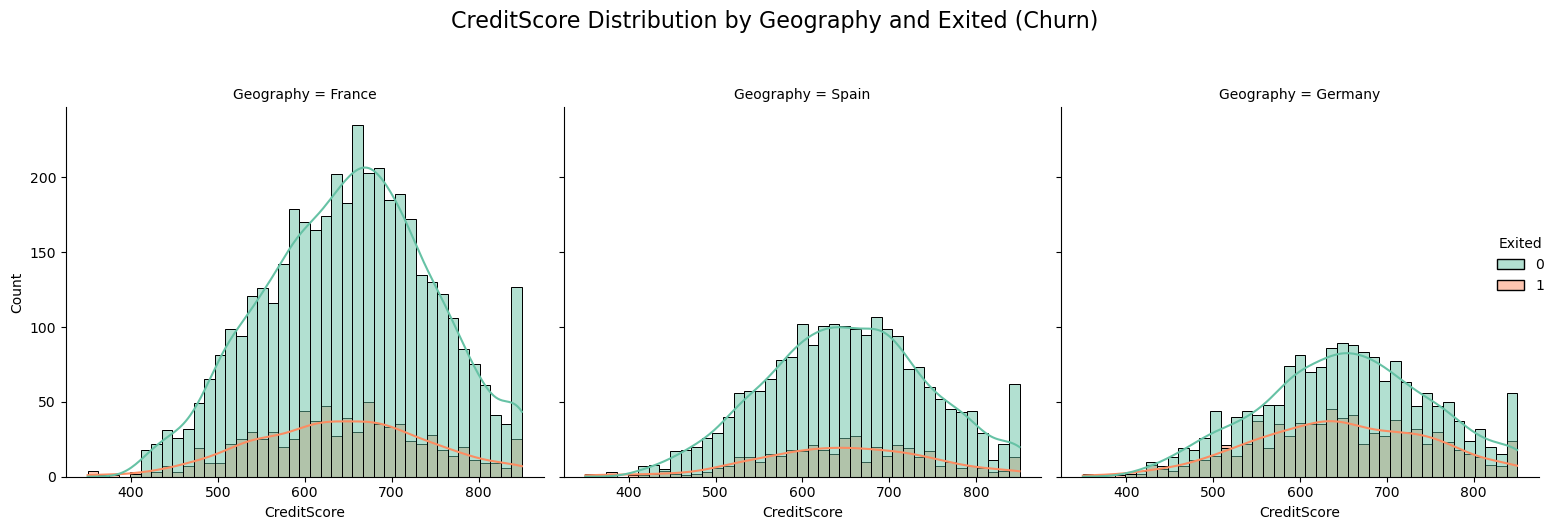

In [28]:
# Create the displot
g = sns.displot(data=df, x="CreditScore", col="Geography", hue="Exited", kde=True, palette='Set2')
g.fig.suptitle('CreditScore Distribution by Geography and Exited (Churn)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

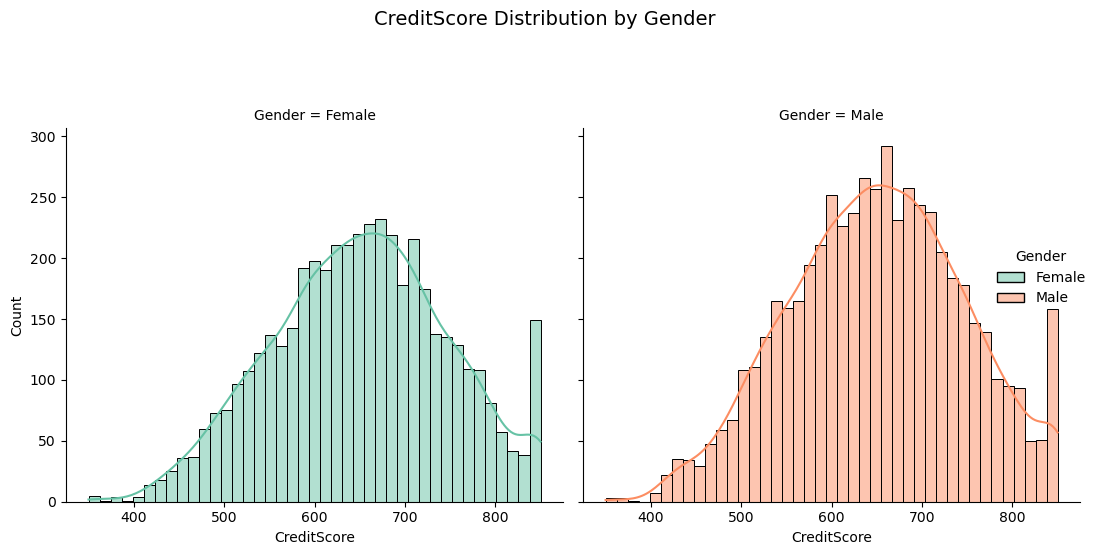

In [29]:
# Create the displot
g = sns.displot(data=df, x="CreditScore", col="Gender", hue="Gender", kde=True, palette='Set2')
g.fig.suptitle('CreditScore Distribution by Gender', fontsize=14, y=1.10)
plt.tight_layout()
plt.show()

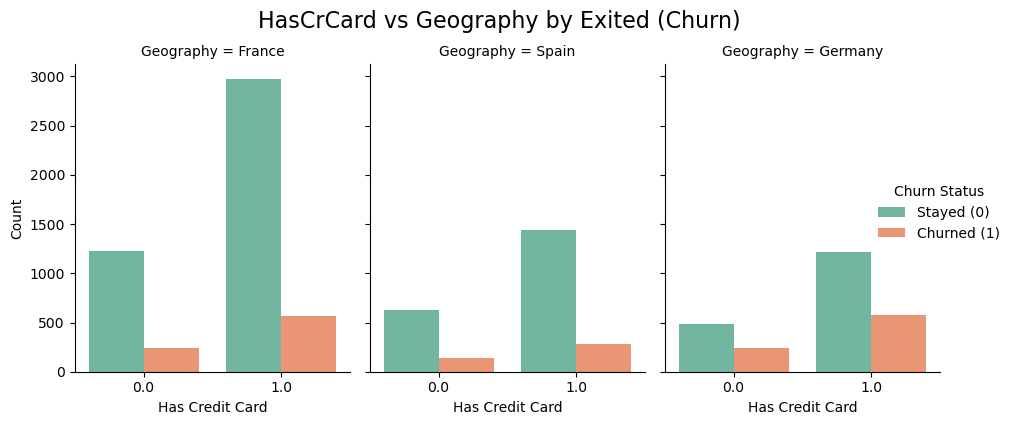

In [30]:
# Create a catplot to visualize HasCrCard vs Geography by Exited
g = sns.catplot(
    data=df, 
    x='HasCrCard', 
    hue='Exited', 
    col='Geography', 
    kind='count',
    palette='Set2',
    height=4, 
    aspect=0.8
)

g.fig.suptitle('HasCrCard vs Geography by Exited (Churn)', fontsize=16, y=1.05)
g.set_axis_labels('Has Credit Card', 'Count')
g._legend.set_title('Churn Status')
new_labels = ['Stayed (0)', 'Churned (1)']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.show()

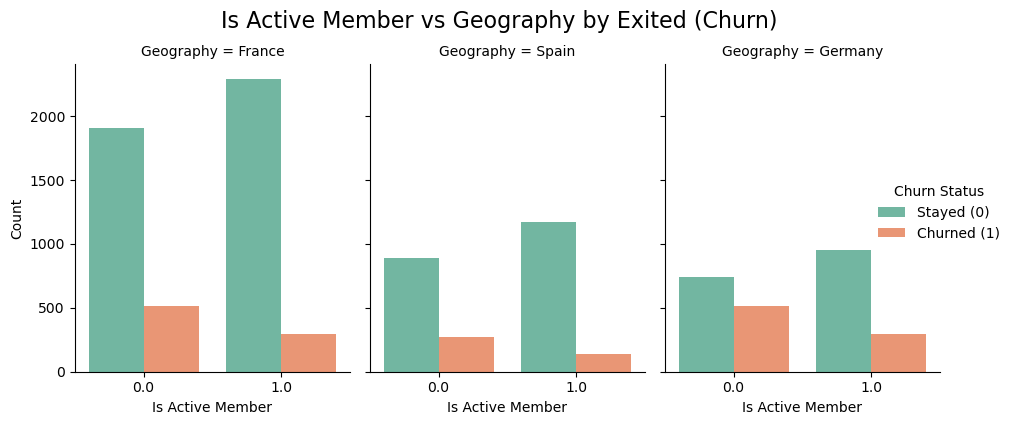

In [31]:
# Create a catplot to visualize IsActiveMember vs Geography by Exited
g = sns.catplot(
    data=df, 
    x='IsActiveMember', 
    hue='Exited', 
    col='Geography', 
    kind='count',
    palette='Set2',
    height=4, 
    aspect=0.8
)

g.fig.suptitle('Is Active Member vs Geography by Exited (Churn)', fontsize=16, y=1.05)
g.set_axis_labels('Is Active Member', 'Count')
g._legend.set_title('Churn Status')
new_labels = ['Stayed (0)', 'Churned (1)']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.show()

# Data Preprocessing


In [32]:
#One-hot encoding for "Geography" column
df_encoded = pd.get_dummies(df, columns=["Geography"])

#binary encoding for Gender
df_encoded["Gender"] = df_encoded["Gender"].map({'Male':0, 'Female':1})

In [33]:
# Display the encoded dataframe
print("Encoded DataFrame Head:\n", df_encoded.head())

Encoded DataFrame Head:
    CreditScore  Gender   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       1  42.0       2       0.00              1        1.0   
1          608       1  41.0       1   83807.86              1        0.0   
2          502       1  42.0       8  159660.80              3        1.0   
3          699       1  39.0       1       0.00              2        0.0   
4          850       1  43.0       2  125510.82              1        0.0   

   IsActiveMember  EstimatedSalary  Exited  Geography_France  \
0             1.0        101348.88       1              True   
1             1.0        112542.58       0             False   
2             0.0        113931.57       1              True   
3             0.0         93826.63       0              True   
4             1.0         79084.10       0             False   

   Geography_Germany  Geography_Spain  
0              False            False  
1              False             True  
2      

In [34]:
# Check the original class distribution
original_class_distribution = df_encoded['Exited'].value_counts()
print("\nOriginal Class Distribution:\n", original_class_distribution)



Original Class Distribution:
 Exited
0    7963
1    2037
Name: count, dtype: int64


In [35]:
# Separate the majority and minority classes
majority_class = df_encoded[df["Exited"] == 0]
minority_class = df_encoded[df["Exited"]==1]

In [36]:
# Oversample the minority class
minority_oversampled = resample(minority_class,replace=True,n_samples = len(majority_class),random_state=42)

In [37]:
# Combine the majority class with the oversampled minority class
data_balanced = pd.concat([majority_class,minority_oversampled])

In [38]:
# Check the new class distribution after oversampling
df_balanced_distribution = data_balanced['Exited'].value_counts()
print("\nNew Class Distribution After Oversampling:\n", df_balanced_distribution)


New Class Distribution After Oversampling:
 Exited
0    7963
1    7963
Name: count, dtype: int64


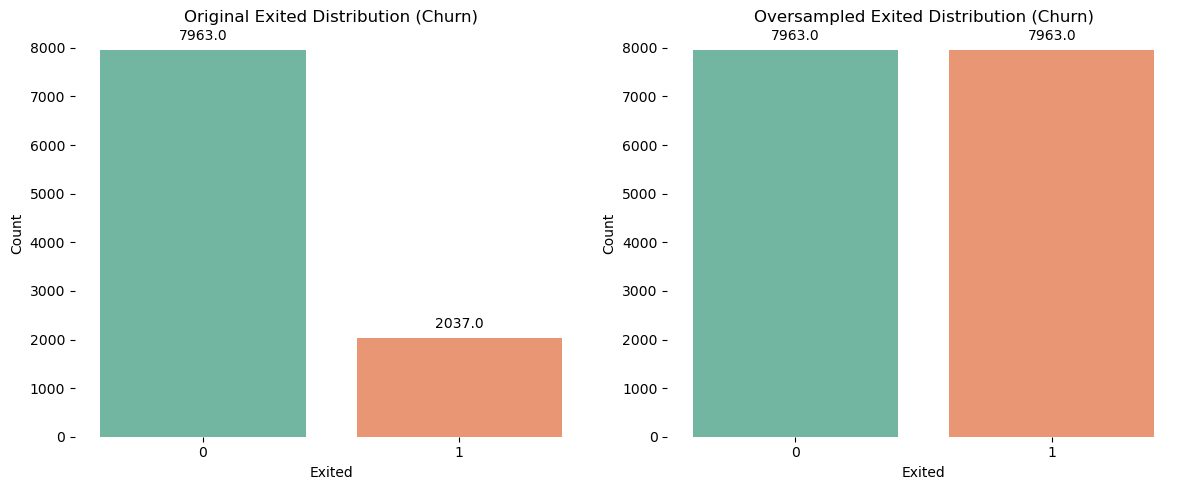

In [39]:
# Visualize the class distribution before and after oversampling
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Original distribution
sns.barplot(x=original_class_distribution.index, y=original_class_distribution, ax=axes[0], palette='Set2')
axes[0].set_title('Original Exited Distribution (Churn)')
axes[0].set_ylabel('Count')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')
sns.despine(left=True, bottom=True)

# New distribution after oversampling
sns.barplot(x=df_balanced_distribution.index, y=df_balanced_distribution, ax=axes[1], palette='Set2')
axes[1].set_title('Oversampled Exited Distribution (Churn)')
axes[1].set_ylabel('Count')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

# 6. Correlation Heatmap

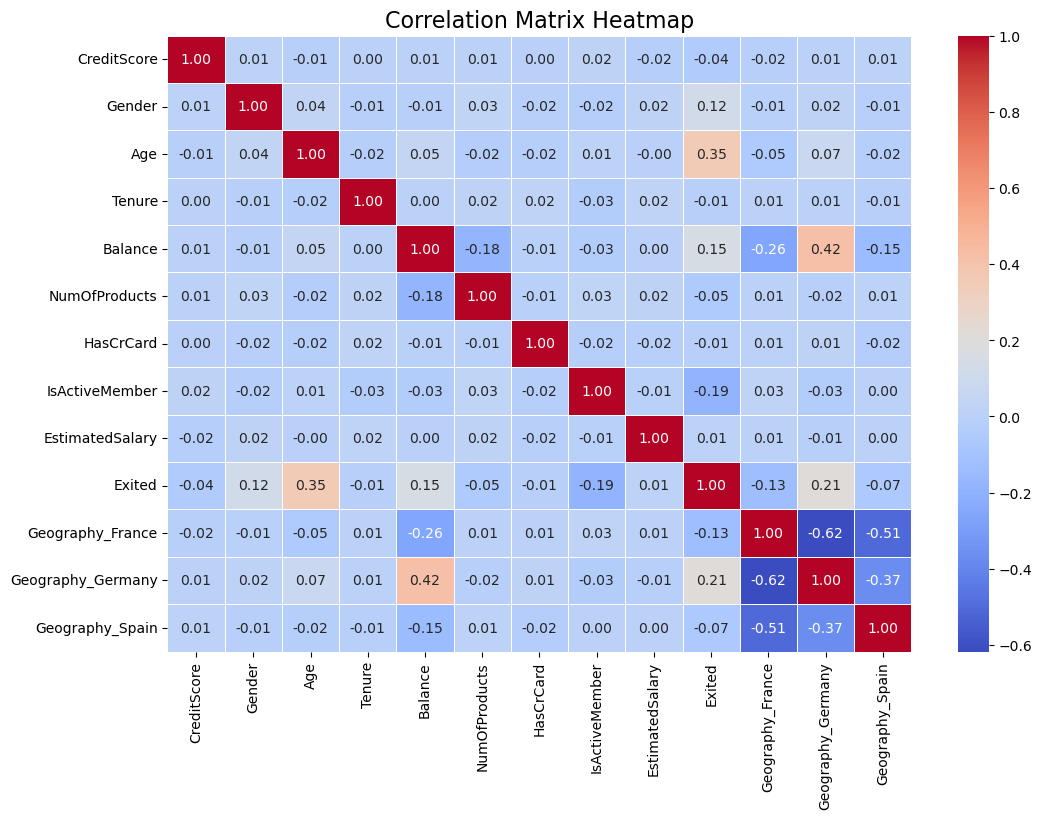

In [40]:
correlation_matrix = data_balanced.corr()
# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

# 7. Modelling

In [41]:
# Define features (X) and target (y)
X = data_balanced.drop("Exited",axis=1)
y = data_balanced["Exited"]
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shape of the training and testing sets
print(f"Training Set: {X_train.shape}, {y_train.shape}")
print(f"Testing Set: {X_test.shape}, {y_test.shape}")

Training Set: (12740, 12), (12740,)
Testing Set: (3186, 12), (3186,)


In [42]:
# Initialize the scaler for features scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
#Initialize models
models = {
    "Logestic Regression": LogisticRegression(random_state = 42),
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XG Boost": XGBClassifier(random_state=42)
}

In [44]:
# Display model names to confirm initialization
print("Models initialized:",list(models.keys()))

Models initialized: ['Logestic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'XG Boost']



Model: Logestic Regression
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1593
           1       0.70      0.68      0.69      1593

    accuracy                           0.70      3186
   macro avg       0.70      0.70      0.70      3186
weighted avg       0.70      0.70      0.70      3186



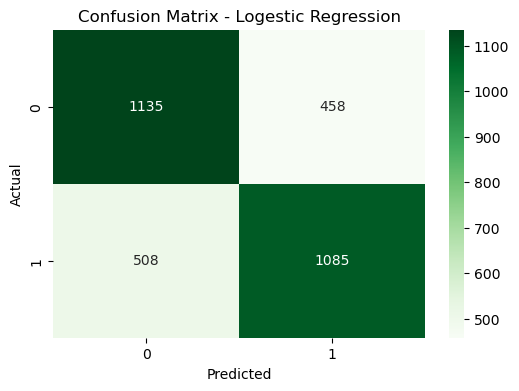


Model: SVM
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1593
           1       0.80      0.80      0.80      1593

    accuracy                           0.80      3186
   macro avg       0.80      0.80      0.80      3186
weighted avg       0.80      0.80      0.80      3186



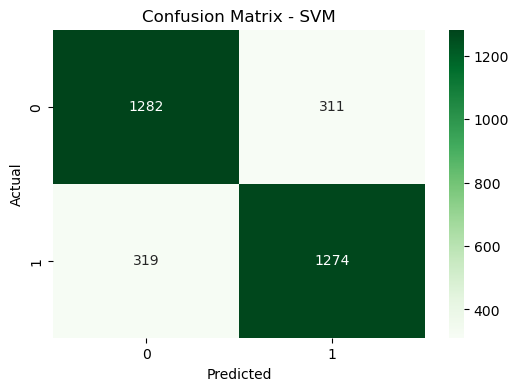


Model: Decision Tree
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1593
           1       0.87      0.98      0.92      1593

    accuracy                           0.92      3186
   macro avg       0.92      0.92      0.92      3186
weighted avg       0.92      0.92      0.92      3186



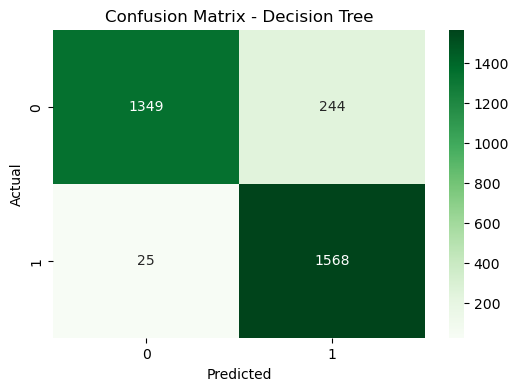


Model: Random Forest
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1593
           1       0.93      0.98      0.95      1593

    accuracy                           0.95      3186
   macro avg       0.95      0.95      0.95      3186
weighted avg       0.95      0.95      0.95      3186



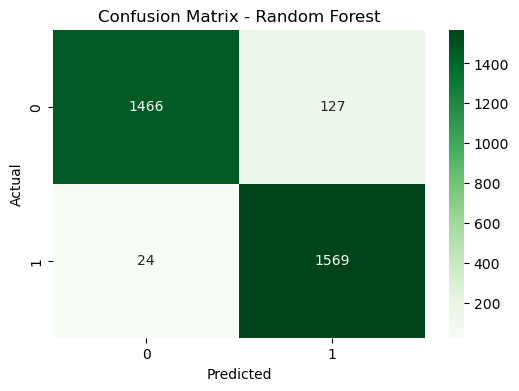


Model: XG Boost
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1593
           1       0.86      0.93      0.90      1593

    accuracy                           0.89      3186
   macro avg       0.90      0.89      0.89      3186
weighted avg       0.90      0.89      0.89      3186



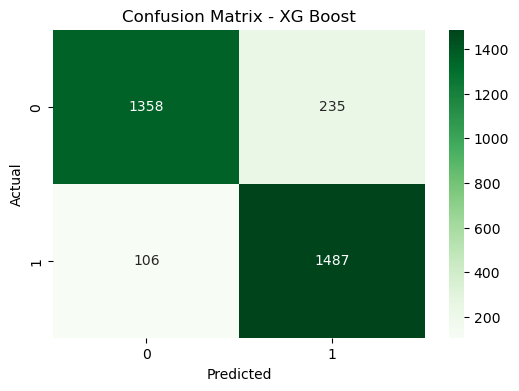


Model Accuracies:
Logestic Regression: 0.6968
SVM: 0.8023
Decision Tree: 0.9156
Random Forest: 0.9526
XG Boost: 0.8930


In [45]:
# Function to train models and display results
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    
    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        
        # Display classification report
        print(f"\nModel: {name}")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    
    return results

# Train and evaluate models
results = train_and_evaluate_models(models, X_train_scaled, X_test_scaled, y_train, y_test)

# Display model accuracies
print("\nModel Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

In [46]:
# Identify the best model
best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]
print(f"\nBest Model: {best_model_name} with Accuracy: {best_model_accuracy:.4f}")


Best Model: Random Forest with Accuracy: 0.9526


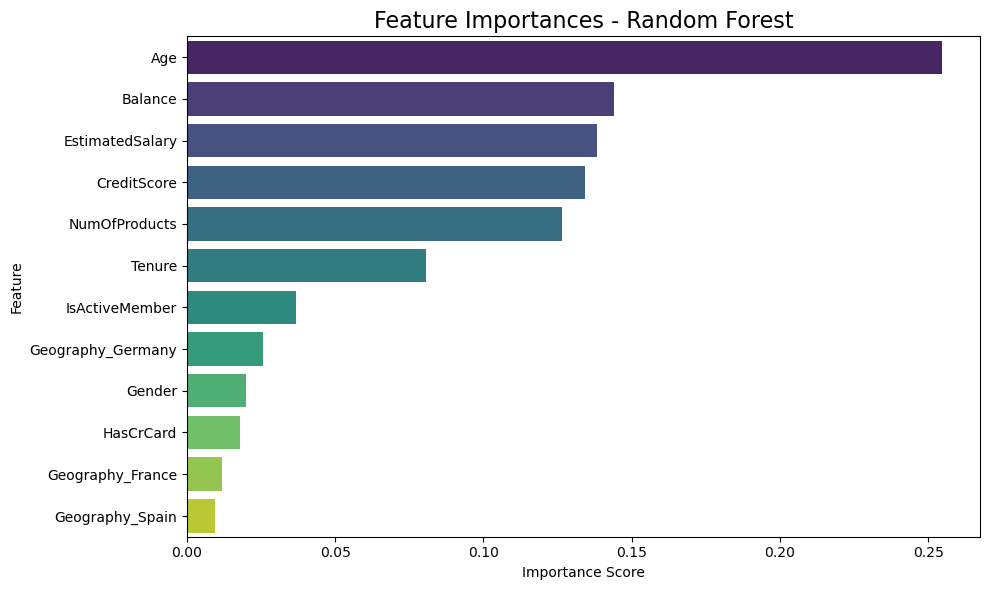

In [47]:
# Plot feature importances if the best model supports it
best_model = models[best_model_name]
feature_importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title(f'Feature Importances - {best_model_name}', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [48]:
# Perform 5-fold cross-validation on the Random Forest model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")

Cross-Validation Scores: [0.93014129 0.9411303  0.93877551 0.93956044 0.93720565]
Mean CV Accuracy: 0.9374
